# Execution time experiments for Fully Connected layers.

In [4]:
from attack_stuff import possible_layers, Pool, Conv, TFv2_Conv, TFv2_FullyConnected

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import time
import rdtsc

import logging

from collections import Counter 
from functools import reduce
import operator
import threading

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

logging.disable(logging.WARNING)

shape = [1024,]

random = tf.constant(np.random.random(size=[1]+shape))


def possible_layers(input_shape):
    for units in [16, 32, 64, 128, 256, 512, 1024]:
        # if the next layer is fully connected, then to the previous layer the
        # Flatten was applied, thus input dim will equal to the product of dims
        yield TFv2_FullyConnected(reduce(operator.mul, input_shape), units)


parameters = []
for n in range(100, 200):
    parameters += [layer.linear_parameters() for layer in possible_layers([n,])]
print(len(parameters))
Counter([p[0] for p in parameters]).most_common(10)

700


[(1600, 1),
 (3200, 1),
 (6400, 1),
 (12800, 1),
 (25600, 1),
 (51200, 1),
 (102400, 1),
 (1616, 1),
 (3232, 1),
 (6464, 1)]

In [8]:
i = 0

for n in range(100, 200):

    shape = [n,]

    random = tf.constant(np.random.random(size=[1]+shape))
    
    inputs = tf.keras.layers.Input(shape)
    x = tf.keras.layers.Dense(n, activation='relu')(inputs)
    x = tf.keras.layers.Dense(n, activation='relu')(x)
    global_model = tf.keras.models.Model(inputs=inputs, outputs=x)
    
    global_model.compile()
    t = get_time2()
    global_model.predict(random)
    global_time = get_time2() - t
    
    for layer in possible_layers(shape):

        tmp_x = layer.generate()(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=tmp_x)
        model.compile()
        res_t = 0
        
        for _ in range(N_RERUN):
            t = get_time2()
            model.predict(random)
            res_t += get_time2() - t
            
        res_t /= N_RERUN
        times.append(res_t - global_time)
        print('\r' * 1000, end='')
        print(f'model {i} of {len(parameters)}, executed in {res_t}ns', end='')

        if not i & ((1 << 10) - 1): 
            with open('times_FC_output.txt', 'w') as file:
                file.write(str(times))
            print(f'\n\n[=>] Writing {i} times to file.\n')
        i += 1

model 0 of 700, executed in 182228025.0ns

[=>] Writing 0 times to file.

model 699 of 700, executed in 247807867.0nss

<IPython.core.display.Javascript object>


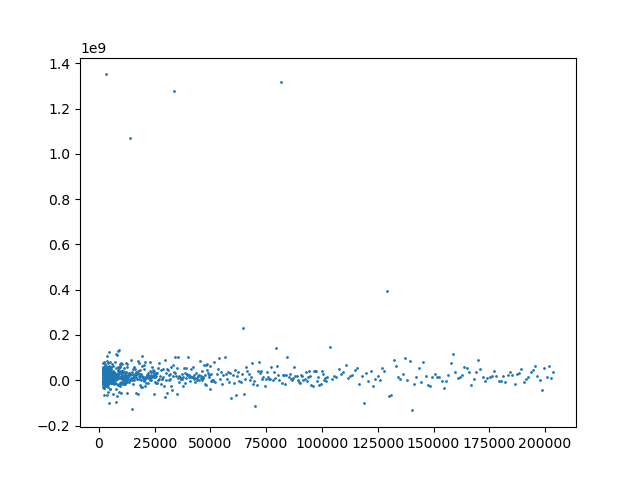

In [9]:
x = [par[0] for par in parameters]
plt.scatter(x, times, s=1)

## Conclusion 

According to information from [paper](https://eprint.iacr.org/2020/1014.pdf): 

```The validator estimates thetheoreticalrunning time of a layerwith parameters 𝜃𝑙 based on the following observation: the execution time of a layer is linear in both its number of multiply-and-accumulate(MAC) operations and the number of cache misses.```

Thus, our experimental data should look like this: 

![linear image](./graphs/linear_values.jpg)

Althought at the previous cell we can observe **no linear model**. 

Next cell demonstrate situation with much more data.

In [2]:
with open('times_FC_6475output.txt', 'r') as file:
    times = eval(file.read())
len(times)

6475

<IPython.core.display.Javascript object>


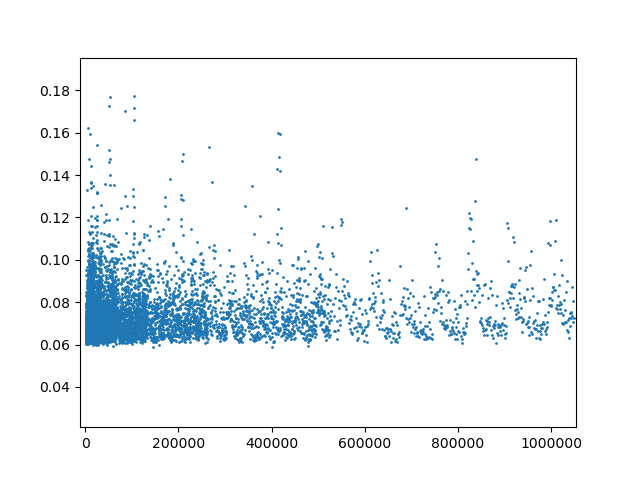

In [5]:
x = [par[0] for par in parameters]

plt.scatter(x, times, s=1)   